In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pygmt
import pyproj
from geopy.distance import geodesic
from scipy.signal import savgol_filter
geodesic = pyproj.Geod(ellps='WGS84')
import os
import importlib

os.chdir("scripts_for_wb/")
import wb_writer
import profile_maker
importlib.reload(wb_writer)
importlib.reload(profile_maker)
os.chdir("../")

/Users/danieldouglas/opt/anaconda3/envs/pygmt-vtk/lib/python3.11/site-packages/pygmt/src/project.py:234: RuntimeWarning: Changing 'output_type' from 'pandas' to 'file' since 'outfile' parameter is set. Please use output_type='file' to silence this warning.
  output_type = validate_output_table_type(output_type, outfile=outfile)


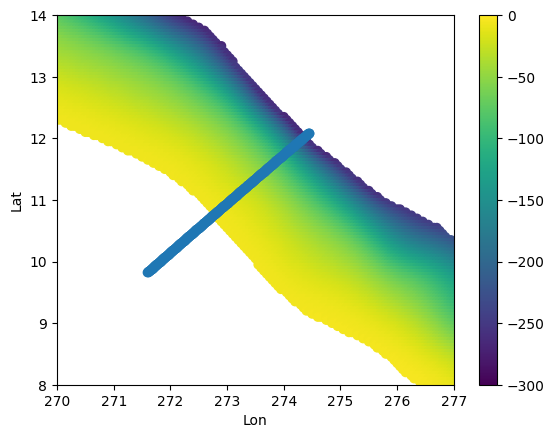

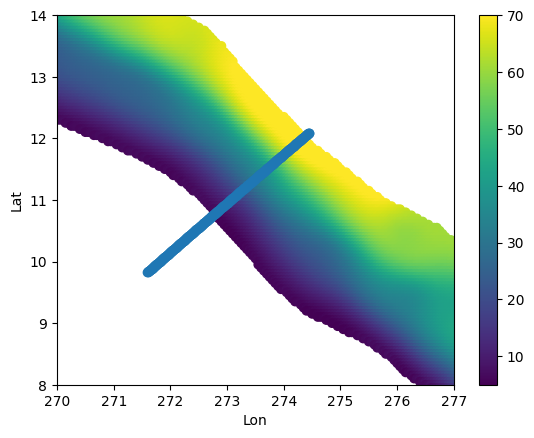

In [2]:
slab2_dir = "/Users/danieldouglas/PyLith_Internship/Slab2_CAM/"
slab2_contours = np.loadtxt(fname=slab2_dir + "cam_slab2_dep_02.24.18_contours.in", comments='>')
slab2_depth_top = np.loadtxt(fname=slab2_dir + "cam_slab2_dep_02.24.18.xyz", delimiter=',')
slab2_depth_top = slab2_depth_top[np.isnan(slab2_depth_top[:, 2]) == False] # Remove NANs

slab2_dips = np.loadtxt(fname=slab2_dir + "cam_slab2_dip_02.24.18.xyz", delimiter=',')
slab2_dips = slab2_dips[np.isnan(slab2_dips[:, 2]) == False] # Remove NANs

transect_coords = np.array([[88.404, 9.8284],
                            [86.472, 11.380]])

fwd_az, back_az, dist = geodesic.inv(transect_coords[0, 0], transect_coords[0, 1], transect_coords[1, 0], transect_coords[1, 1])
spacing_of_profiles = 1.0
max_profile_length  = 400
pygmt.project(center=[transect_coords[0][0], transect_coords[0][1]], azimuth=fwd_az, outfile="test.txt",
              generate=spacing_of_profiles, length=[0, max_profile_length], unit=True)

profile = np.loadtxt(fname="test.txt")
profile[:, 0] = 360 - profile[:, 0]
plt.scatter(slab2_depth_top[:, 0], slab2_depth_top[:, 1], c=slab2_depth_top[:, 2], vmin=-300, vmax=0)
plt.colorbar()
plt.scatter(profile[:, 0], profile[:, 1])
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.xlim(270, 277)
plt.ylim(8, 14)
plt.show()

plt.scatter(slab2_dips[:, 0], slab2_dips[:, 1], c=slab2_dips[:, 2], vmin=5, vmax=70)
plt.colorbar()
plt.scatter(profile[:, 0], profile[:, 1])
plt.xlabel("Lon")
plt.ylabel("Lat")
plt.xlim(270, 277)
plt.ylim(8, 14)
plt.show()

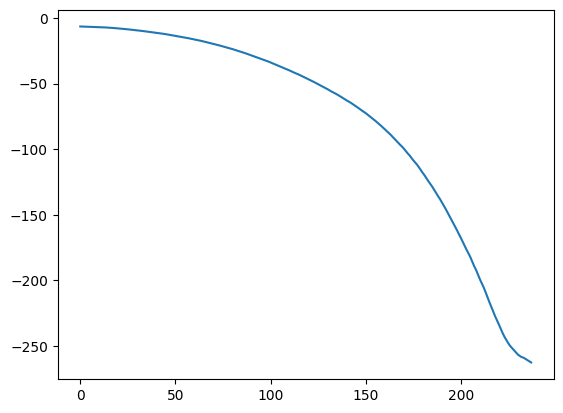

In [170]:
from geopy.distance import distance
# Calculate the distance between profile and slab point
# Loop through all profile
lat_spacing, lon_spacing = 0.1, 0.1
max_point_distance = 10

for j in range(len(profile)):
    # Find all slab points within a specified lon/lat of a given profile point
    slab_indices = np.where( (profile[j, 1] <= slab2_depth_top[:, 1] + lat_spacing) & (profile[j, 1] >= slab2_depth_top[:, 1] - lat_spacing) & \
                             (profile[j, 0] <= slab2_depth_top[:, 0] + lon_spacing) & (profile[j, 0] >= slab2_depth_top[:, 0] - lon_spacing))[0]

    # If there aren't any slab points, return 0
    if len(slab_indices) == 0:
        profile[j] = 0
        profile_slab_distances = [0]
        
    # Otherwise calculate distance for all slab points
    else:
        profile_slab_distances  = [] #  Variable to store the distance between profile point and slab point
        for k in slab_indices:
            # Calculate the distance between the current profile and slab point
            profile_slab_distances.append(distance((profile[j, 1], profile[j, 0]), (slab2_depth_top[k, 1], slab2_depth_top[k, 0])).km)
        
        profile_slab_weights = np.zeros(len(profile_slab_distances)) # Variable for storing weights for each slab point
        
        # Iterate through each distance to compute a corresponding weight for later averaging
        for w in range(len(profile_slab_weights)):
            # if distance is very small, assign high weight (avoids potential divide by 0 error)
            if profile_slab_distances[w] <= 1e-10:
                profile_slab_weights[w] = 1e10
                
            # Otherwise weight is inverse of slab distance
            else:
                profile_slab_weights[w] = 1./profile_slab_distances[w]
                
                # If the distance to point is greater than the allowed max_distance, discard by setting weight to 0 
                if profile_slab_weights[w] < (1./ max_point_distance):
                    profile_slab_weights[w] = 0

        # If all weights are 0, set all weights to 1 to avoid averaging error
        if np.sum(profile_slab_weights) == 0.:
            profile_slab_weights[:] = 1
        
        for w in range(len(slab2_depth_top[:, 2][slab_indices])):
            if np.isnan(slab2_depth_top[:, 2][slab_indices][w]):
                slab2_depth_top[:, 2][slab_indices][w] = 0
        profile[j, 2] = np.average(slab2_depth_top[:, 2][slab_indices], weights=profile_slab_weights)
        if (np.min(profile_slab_distances) > max_point_distance):
            profile[j, 0] = 0.
            profile[j, 1] = 0.

# Remove profile points past slab edge
nonzero             = np.where(profile[:, 0] != 0.)
profile_within_slab = np.copy(profile[nonzero])
profile_within_slab[:, 2] = savgol_filter(profile_within_slab[:, 2], window_length=10, polyorder=1)
# Save profiles
horizontal_distance = np.arange(0, len(profile_within_slab[:, 2]) * spacing_of_profiles, spacing_of_profiles)
np.savetxt("slab_top_profile.txt", profile_within_slab, delimiter=' ', fmt='%13.8f')

plt.plot(horizontal_distance, profile_within_slab[:, 2])
plt.show()

In [171]:
profile_within_slab[0]

array([272.71598667,  10.72540353,  -6.41905404])

In [181]:
world_builder_file = "test.wb"

os.system("rm " + world_builder_file)
world_builder_file = open(world_builder_file, 'a+')
world_builder_file.write('{\n')
world_builder_file.write('  "version":"1.1",\n')
world_builder_file.write('  "cross section":' + str([[0,0],[100,0]]) + ',\n')
# world_builder_file.write('  "coordinate system":{"model":"cartesian"},\n')
world_builder_file.write('  "features":\n')
world_builder_file.write('  [\n\n')

########################################################### UPPER MANTLE ########################################################################################

thermal_model = 'plate model'

min_x, max_x = -1000, 1000e3
min_y, max_y = -1000, 1000

trench_x, trench_y = 200e3, 0.0

dip_point = [trench_x + 1000e6, trench_y]

x_bounds = [min_x, max_x]
y_bounds = [min_y, max_y]

feature_type = 'mantle layer'
feature_description = 'Upper Mantle'
min_depth = 0
max_depth = 660e3
coordinates = [[np.min(x_bounds), np.min(y_bounds)], [np.min(x_bounds), np.max(y_bounds)], \
               [np.max(x_bounds), np.max(y_bounds)], [np.max(x_bounds), np.min(y_bounds)]]

composition_model = 'uniform'
composition_0 = 0
max_depth_0 = 660e3
min_depth_0 = 0

world_builder_file.write('{\n')
world_builder_file.write(wb_writer.model_feature_string(feature_type, feature_description, min_depth, max_depth, coordinates, dip_point=0))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_0, max_depth_0, min_depth_0))
world_builder_file.write('},\n\n')

########################################################### OVERRIDING PLATE ########################################################################################

feature_type = 'oceanic plate'
feature_description = 'Overriding plate'
overriding_coords = [[np.max(x_bounds), np.min(y_bounds)], [np.max(x_bounds), np.max(y_bounds)], \
                     [trench_x, np.max(y_bounds)], [trench_x, np.min(y_bounds)]]

min_depth = 0
max_depth = 80e3

temp_model = "linear"
temp_max = 80e3
temp_min = 0.0
bot_temp = -1
top_temp = 300

composition_model = 'uniform'
composition_1 = 1
max_depth_1   = 80e3
min_depth_1   = 0

world_builder_file.write('{\n')
world_builder_file.write(wb_writer.model_feature_string(feature_type, feature_description, min_depth, max_depth, overriding_coords, dip_point=0))
world_builder_file.write(wb_writer.linear_model(temp_model, temp_max, temp_min, bot_temp, top_temp, 'both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_1, max_depth_1, min_depth_1))
world_builder_file.write('},\n\n')

########################################################### UNSUBDUCTIED PACIFIC PLATE ########################################################################################

feature_type = 'oceanic plate'
feature_description = 'Subducting plate'
subducting_coords = [[np.min(x_bounds), np.min(y_bounds)], [np.min(x_bounds), np.max(y_bounds)], \
                     [trench_x, np.max(y_bounds)], [trench_x, np.min(y_bounds)]]

min_depth = 0
max_depth = 120e3

temp_max = 120e3
temp_min = 0.0
bot_temp = -1
top_temp = 300
spr_vel = 0.08
CAM_plate_age = 22e6
ridge_distance = CAM_plate_age * spr_vel
subducting_ridge_coords = [[[trench_x - ridge_distance, np.min(y_bounds)], [trench_x - ridge_distance, np.max(y_bounds)]]]

composition_model = 'uniform'
composition_2 = 2
max_depth_2   = 120e3
min_depth_2   = 0

world_builder_file.write('{\n')
world_builder_file.write(wb_writer.model_feature_string(feature_type, feature_description, min_depth, max_depth, subducting_coords, dip_point=0))
world_builder_file.write(wb_writer.cooling_model(thermal_model, temp_max, temp_min, bot_temp, top_temp, spr_vel, subducting_ridge_coords, first_or_last='both'))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_2, max_depth_2, min_depth_2, first_or_last='both'))
world_builder_file.write('},\n\n')

########################################################### SUBDUCTIED PACIFIC PLATE ########################################################################################

feature_description = 'Slab'
feature_types = 'subducting plate'

feature_coordinates = [[trench_x, np.min(y_bounds)], [trench_x, np.max(y_bounds)]]

world_builder_file.write('    {' + wb_writer.model_feature_string(feature_types, feature_description, 0, 10000e3, feature_coordinates, dip_point, is_subducting=True))

segment_num = len(horizontal_distance)
total_sections = 2
segment_thickness = 120e3
is_subducting = True
density = 3300
couple_depth = 80e3
taper = 0
max_slab_top = 120e3
min_slab_top = -240e3
top_truncation = [-120e3]
first_or_last = 'both'
composition_model = 'uniform'

# This loop initializes the slab with the correct number of segments
world_builder_file.write('"segments":[\n')
for i in range(segment_num):
    if i != segment_num - 1:
        world_builder_file.write('{"length":0, "thickness":[0.0], "angle":[0]},\n')
    else:
        world_builder_file.write('{"length":0, "thickness":[0.0], "angle":[0]}],\n\n')

# This loops through all sections and determines the thickness, dip, and length of each segment
world_builder_file.write('    "sections":[')
for j in range(total_sections):

    slab_length = 0
    segment_length = []
    dip_holder = [0]


    segment_thickness = []
    for i in range(1, len(profile_within_slab)):
        segment_thickness.append([slab_thickness])        
        slab_length = np.sqrt( (horizontal_distance[i] - horizontal_distance[i - 1])**2 + (profile_within_slab[:, 2][i] - profile_within_slab[:, 2][i - 1])**2 )

        riserun = (profile_within_slab[:, 2][i - 1] - profile_within_slab[:, 2][i]) / (horizontal_distance[i] - horizontal_distance[i - 1])
        segment_length.append(slab_length * 1000)
        dip_holder.append(np.rad2deg(np.arctan(abs(riserun))))

    dips = []
    for k in range(len(dip_holder) - 1):
        if k != int(len(dip_holder) - 1):
            dips.append([dip_holder[k], dip_holder[k + 1]])
        else:
            dips.append([dip_holder[k]])

    # Write to the World Builder File
    world_builder_file.write('    {"coordinate":' + str(j) + ',\n')
    world_builder_file.write('     "segments":[')
    for current_segment in range(segment_num):
        if fill_segments == 'end':
            world_builder_file.write('    ' + wb_writer.segment_string_at_end(segment_length, segment_thickness, dips, top_truncation, j, total_sections, segment_num, current_segment))
        elif fill_segments == 'start':
            world_builder_file.write('    ' + wb_writer.segment_string(segment_length, segment_thickness, dips, top_truncation, j, total_sections, segment_num, current_segment))

world_builder_file.write('    ],\n')
world_builder_file.write(wb_writer.mass_conserving_model(thermal_model, density, spr_vel, couple_depth, subducting_ridge_coords, taper, max_slab_top, min_slab_top, first_or_last))
world_builder_file.write(wb_writer.composition_feature_string(composition_model, composition_2, 100000e3, 0, is_subducting=True, first_or_last='both'))
world_builder_file.write('}\n\n')
world_builder_file.write(']\n')
world_builder_file.write('}')
world_builder_file.close()

In [11]:
200e3 - 22e6 * 0.085

-1670000.0000000002